# Q Learning

## Libraries


In [4]:
import gym # game environment
import numpy as np # for stats
import random # to generate uniform random number
import time # to time algorithm runtime
from tqdm import tqdm # lib to display a charging bar of for iterations to estimate runtime
import metrics_m as mm # handmade library for metrics plotting + computation
import optuna # optimization lib
import pprint
from IPython.display import clear_output

## Core algorithm
### Q-Learning algorithm
There is no written rules to follow for the agent, instead it will learn from experience. Because the agent is greedy to get the best reward it will find the best solution by reading its Q-Table.

### Q-Table
It is a table that stores the Q-value for each action.
The Q-Table will be updated by the Q-Learning algorithm it behaves like a recursive function.

#### Q-Table parameters
- Alpha: learning rate: how much the agent will learn from the experience, how much the Q table would be updated
- Gamma: discount factor: how much the agent will consider future rewards, how much confidence would be given to the future rewards
- Q-Values: it is a mapping of a state-action pair to a real number related to the expected reward. The next Q-Value is created by adding the old one with a new learned value and taking into account the potential maximum reward.

#### Q-Table update process
1. init Q table with random values, likely zeroes
2. exploration: choose a random action (a) for the current state (s)
3. move to a next state (s') by taking the action (a)
4. select the the highest Q-Value for the next state (s')
5. update Q-Table with the new value using the equation
6. set the next state as the current state
7. repeat until the goal is reached, and repeat the process

In [5]:
def fit(alpha, epsilon, gamma, nb_games):

    # For plotting metrics
    all_penalties = []
    all_games_steps_counts = []
    all_games_times = []
    all_games_rewards = []
    max_reward = float("-inf")
    min_reward = float("+inf")

    # q table initalization
    Q_table = np.zeros([env.observation_space.n, env.action_space.n])

    # Repeat of x number of games
    for i in tqdm(range(nb_games)):
        # To store the runtime
        t0 = time.time()

        # Variables
        state = env.reset()
        steps_count, penalties, reward = 0, 0, 0
        done = False
        rewards = []
        
        # Until the game is ended
        while not done:
            # Exploration vs exploit decision making   
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(Q_table[state]) # Exploit learned values

            # Take the action
            next_state, reward, done, info = env.step(action) 

            # Store reward for later use
            rewards.append(reward)
            
            # Update Q_table values
            old_value = Q_table[state, action]
            next_max = np.max(Q_table[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            Q_table[state, action] = new_value

            # Consider a penality if reward -10 (if the agent pick-up or drop-off passenger at a wrong location)
            if reward == -10:
                penalties += 1
            
            cumulative_rewards = sum(rewards)
            state = next_state
            steps_count += 1

            if cumulative_rewards > max_reward:
                max_reward = cumulative_rewards
            if cumulative_rewards < min_reward:
                min_reward = cumulative_rewards
        
        # Feed algorithms data for later metrics
        all_penalties.append(penalties)
        all_games_steps_counts.append(steps_count)
        all_games_times.append(time.time()-t0)
        all_games_rewards.append(np.mean(rewards))
        


    # Return run data
    return_dict = {
        "steps" : all_games_steps_counts,
        "Q_table" : Q_table,
        "games_times" : all_games_times,
        "rewards" : all_games_rewards,
        "penalties" : all_penalties,
        "max_reward" : max_reward,
        "min_reward" : min_reward
    }   
    return return_dict


## Optimization
Overall, optimizing a ML model is about trying different values for it's hyperparameter to find the one that gives the best results.
Here we want we have 4 parameters that we will want to use for that :
* Alpha = between 0 and 1
* Epsilon = between 0 and 1
* Gamma = between 0 and 1
* Number of games = between 10000 and 30000 unless the optimization takes too long

To make this optimization step automatic, we use `optuna` which is a python library that already implement this behaviour.

In [6]:
def objective(trial):
    results = fit(trial.suggest_float("alpha", 0, 1 ), trial.suggest_float("epsilon", 0, 1 ), trial.suggest_float("gamma", 0, 1 ), trial.suggest_int("nb_games", 10000, 30000 ) )
    return min(results["steps"])

# Environment
env = gym.make("Taxi-v3").env
env.reset()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
print(study.best_params)

[I 2022-06-16 13:52:28,585] A new study created in memory with name: no-name-ef2d3cbb-6a69-4f5d-974d-98a5263010a2
100%|██████████| 20220/20220 [00:09<00:00, 2209.90it/s]
[I 2022-06-16 13:52:37,743] Trial 0 finished with value: 6.0 and parameters: {'alpha': 0.7129417050963287, 'epsilon': 0.017625824030326642, 'gamma': 0.604383852803089, 'nb_games': 20220}. Best is trial 0 with value: 6.0.
100%|██████████| 18971/18971 [00:24<00:00, 776.64it/s] 
[I 2022-06-16 13:53:02,175] Trial 1 finished with value: 6.0 and parameters: {'alpha': 0.033212385823653046, 'epsilon': 0.2599248891113667, 'gamma': 0.746344587388993, 'nb_games': 18971}. Best is trial 0 with value: 6.0.
100%|██████████| 17043/17043 [00:12<00:00, 1399.45it/s]
[I 2022-06-16 13:53:14,359] Trial 2 finished with value: 6.0 and parameters: {'alpha': 0.26202991696240974, 'epsilon': 0.032858548970154056, 'gamma': 0.8007403948331561, 'nb_games': 17043}. Best is trial 0 with value: 6.0.
100%|██████████| 15945/15945 [05:11<00:00, 51.25it/s]

{'alpha': 0.7129417050963287, 'epsilon': 0.017625824030326642, 'gamma': 0.604383852803089, 'nb_games': 20220}


## Training

In [7]:
# Environment
env = gym.make("Taxi-v3").env

# Hyperparameters
alpha = study.best_params["alpha"]
epsilon = study.best_params["epsilon"]
gamma = study.best_params["gamma"]
nb_games = study.best_params["nb_games"]

results = fit(alpha, epsilon, gamma, nb_games)

print(results.keys())

100%|██████████| 20220/20220 [00:10<00:00, 2018.77it/s]

dict_keys(['steps', 'Q_table', 'games_times', 'rewards', 'penalties', 'max_reward', 'min_reward'])


## Metrics

### Steps

#### Graph

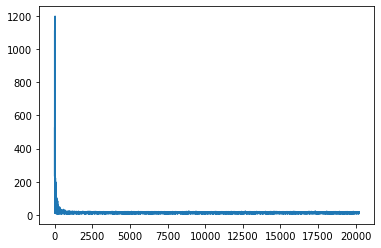

{'q1': 11.0, 'median': 13.0, 'q3': 15.0, 'max': 1199, 'min': 6}

In [8]:
mm.statMetrics(results["steps"], plot=True)

#### Better and worst

In [9]:
mm.minmaxMetrics(results["steps"])

{'min': 6, 'min_game': 180, 'max': 1199, 'max_game': 28}

### Rewards

#### Graph

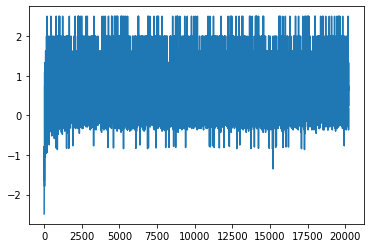

{'q1': 0.3125,
 'median': 0.5,
 'q3': 0.75,
 'max': 2.5,
 'min': -2.4885496183206106}

In [10]:
mm.statMetrics(results["rewards"], plot=True)

### Better and worst

In [11]:
mm.minmaxMetrics(results["rewards"])

{'min': -2.4885496183206106, 'min_game': 0, 'max': 2.5, 'max_game': 180}

In [12]:
print(f"Overall games min reward : { results['min_reward'] } ")
print(f"Overall games max reward : { results['max_reward'] }")

Overall games min reward : -2427 
Overall games max reward : 15


### Runtime

#### Graph

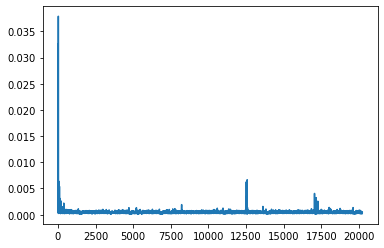

{'q1': 0.0003609657287597656,
 'median': 0.0004298686981201172,
 'q3': 0.0005040168762207031,
 'max': 0.03787803649902344,
 'min': 0.0001442432403564453}

In [13]:
mm.statMetrics(results["games_times"], plot=True)

#### Better and worst

In [14]:
mm.minmaxMetrics(results["games_times"])

{'min': 0.0001442432403564453,
 'min_game': 4878,
 'max': 0.03787803649902344,
 'max_game': 28}

### Win/Lose Rates
This algorithm has no need to have any win/lose rates because on the training it doesn't have any timeout (about steps max) nor stops at any fails so basically the winrate will be 100% anyway so it's a irrelevant metrics for this one

The output is the better of the X trials we tried.


## Test

In [16]:
# Environment
env = gym.make("Taxi-v3").env
env.reset()

# Useful variables
steps = 0
done = None
history = []

# Run the game !
while not done:
    env.render()
    time.sleep(1.5)
    steps += 1
    state = env.s
    action = np.argmax(results["Q_table"][state]) 
    next_state, reward, done, info = env.step(action) 
    clear_output()

print(f"This game was resolved in { steps } steps")


This game was resolved in 8 steps
